## Dataset and Dataloader

In [1]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor  # turns image data into tensors
from torch.utils.data import DataLoader

# Load MNIST using torchvision
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # convert to tensor
        transforms.Normalize((0.1307,), (0.3081,)),  # standardizes pixel values
    ]
)
# Create datasets for training & validation, download if necessary
train_dataset = datasets.MNIST("./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST("./data", train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
loaders = {
    "train": DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0),
    "test": DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0),
}

### Visual of Data

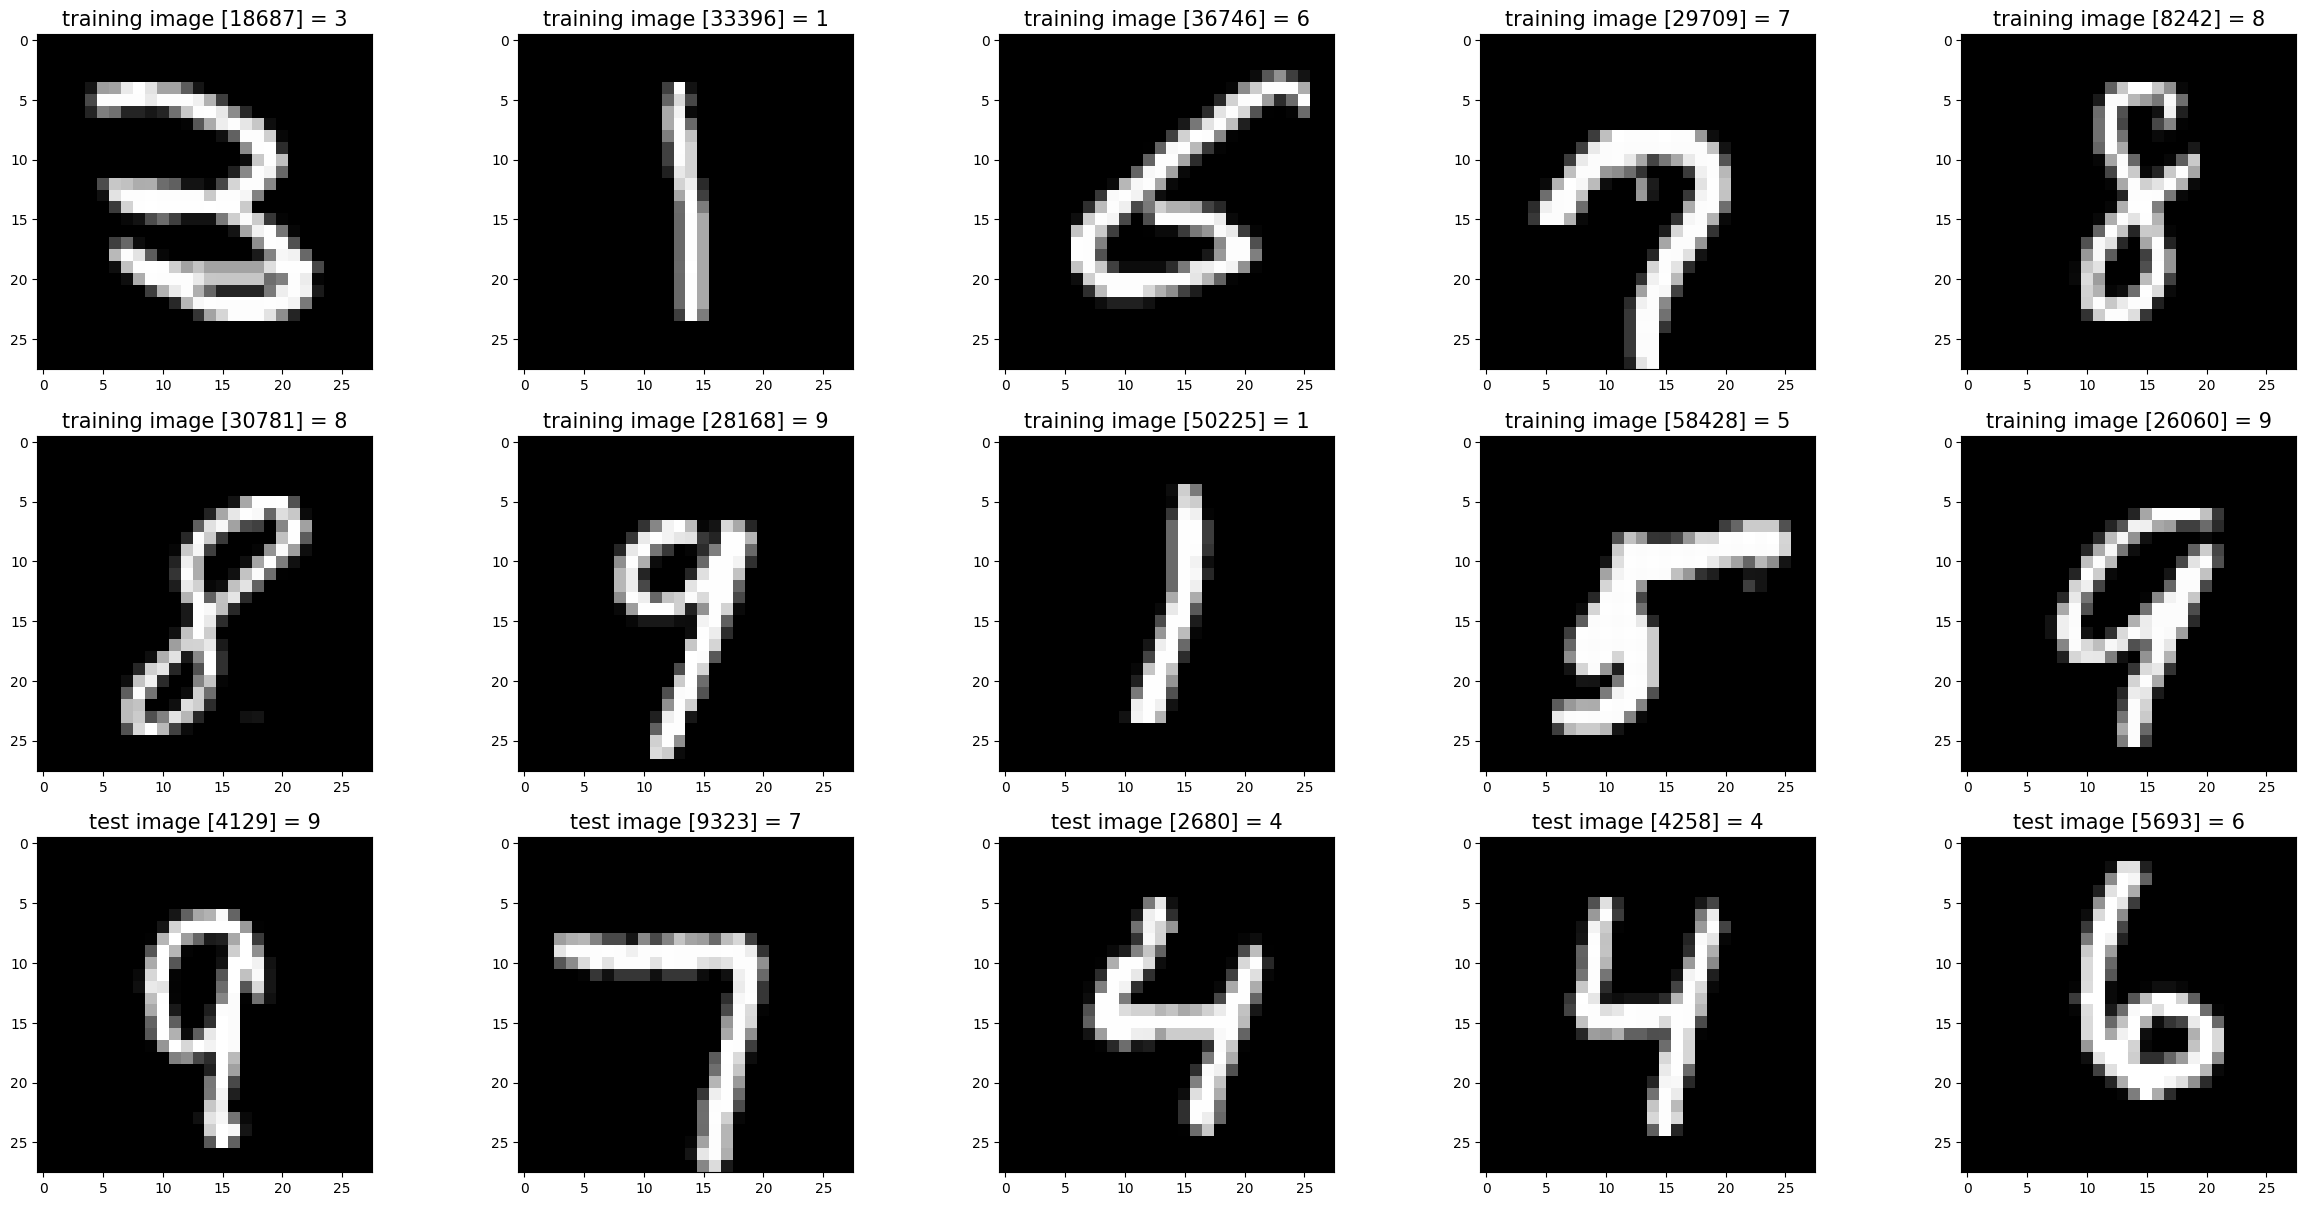

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as py

x_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

images_2_show = []
titles_2_show = []


def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if title_text != "":
            plt.title(title_text, fontsize=15)
        index += 1


for i in range(10):
    r = random.randint(0, 59999)
    images_2_show.append(x_train[r])
    titles_2_show.append(f"training image [{r}] = {y_train[r]}")

for i in range(5):
    r = random.randint(0, 9999)
    images_2_show.append(x_test[r])
    titles_2_show.append(f"test image [{r}] = {y_test[r]}")

show_images(images_2_show, titles_2_show)

### Checking logistics

In [3]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [4]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [5]:
train_dataset.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [6]:
train_dataset.data.shape  # one channel, 28x28 pixels

torch.Size([60000, 28, 28])

In [7]:
train_dataset.targets.size()

torch.Size([60000])

In [8]:
train_dataset.targets  # digits from 0-9

tensor([5, 0, 4,  ..., 5, 6, 8])

# Defining Model's Class

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  # optimization module


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        # ^regularization layer,
        # ignores nodes randomly during TRAINING,
        # irrelevant in TESTING,
        # doesn't change shape of data
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # x.view(-1, 320)  # 20*4*4 = 320; flattening 320 nodes
        x = x.view(x.size(0), -1)  # flattening 320 nodes
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        # return F.softmax(x, dim=1)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [10]:
import torch
import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)  # cpu is slower than GPU

model = Net().to(
    device
)  # must move model, tensors, etc. to GPU if using cuda device (i have no idea what cuda device is)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter("runs/cnn_model_{}".format(timestamp))

# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()


def train(epoch):
    model.train()  # model put into training mode (important for dropout and batchnormalization)
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)  # move to GPU if using cuda
        optimizer.zero_grad()  # zero the parameter gradients
        output = model(data)  # forward pass
        loss = loss_fn(output, target)  # compute loss
        loss.backward()  # backward pass
        optimizer.step()  # optimize weights

        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)}"
                f" ({100.0 * batch_idx / len(loaders['train']):.0f}%)]\tLoss: {loss.item():.6f}",
            )
            model_path = "model_{}_{}".format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)
    writer.add_scalar(
        "Loss/train", loss.item(), epoch * len(loaders["train"]) + batch_idx
    )
    writer.flush()


def test():
    model.eval()  # put model into evaluation mode

    test_loss = 0
    correct = 0

    with torch.no_grad():  # no need to track gradients during evaluation
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders["test"].dataset)

    print(
        f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)}"
        f" ({100.0 * correct / len(loaders['test'].dataset):.0f}%)\n"
    )

In [ ]:
for epoch in range(1, 11):  # 10 epochs
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.359215
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.209499
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.893368
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.319569
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.984238
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.724025

Test set: Average loss: 0.0040, Accuracy: 53623/60000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.641066
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.544814


## Accuracy Metrics

In [ ]:
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)


def evaluate_cnn(model, dataloader, device="cpu", average="macro"):
    """
    Evaluate a PyTorch CNN on a multi-class dataset using scikit-learn metrics.

    Parameters:
    - model: trained PyTorch model
    - dataloader: DataLoader for test/validation data
    - device: 'cpu' or 'cuda'
    - average: averaging method for multi-class metrics ('macro', 'micro', 'weighted')

    Returns:
    - Dictionary with accuracy, precision, recall, f1, and classification report
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            preds = outputs.argmax(dim=1)  # get predicted class
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    metrics = {
        "accuracy": accuracy_score(all_labels, all_preds),
        "precision": precision_score(all_labels, all_preds, average=average),
        "recall": recall_score(all_labels, all_preds, average=average),
        "f1": f1_score(all_labels, all_preds, average=average),
        "report": classification_report(all_labels, all_preds),
    }

    return metrics


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
metrics = evaluate_cnn(model, loaders["test"], device=device, average="macro")

print("Accuracy:", metrics["accuracy"])
print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1 Score:", metrics["f1"])
print(metrics["report"])


Accuracy: 0.92795
Precision: 0.9275678224015922
Recall: 0.9272104475312541
F1 Score: 0.9272339302245027
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5923
           1       0.96      0.97      0.97      6742
           2       0.94      0.91      0.93      5958
           3       0.92      0.90      0.91      6131
           4       0.93      0.91      0.92      5842
           5       0.90      0.92      0.91      5421
           6       0.95      0.97      0.96      5918
           7       0.92      0.95      0.93      6265
           8       0.93      0.88      0.90      5851
           9       0.87      0.90      0.89      5949

    accuracy                           0.93     60000
   macro avg       0.93      0.93      0.93     60000
weighted avg       0.93      0.93      0.93     60000



In [ ]:
device

## Visualize predictions 
- by changing number in test_dataset[num]

In [ ]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_dataset[4]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f"Prediction: {prediction}")

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap="gray")
plt.show()

## Saving the model to path

In [ ]:
torch.save(model.state_dict(), "numreader.pth")
saved_model = Net()
saved_model.load_state_dict(torch.load("numreader.pth"))